# Import libraries

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import re
import seaborn as sns
import plotly.express as px
import itertools
from gensim.models import KeyedVectors
from keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten
from keras.models import Sequential, load_model, model_from_config
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import cohen_kappa_score
from collections import Counter 
from nltk.corpus import stopwords
import pickle

# Global variables definition

In [2]:
ENCODING = "ISO-8859-1"
LSTM_PREDICTIONS = "LSTM_pred.pickle"

# Custom function definition

In [3]:
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
    
def clean_stopwords(words_list):
    return [word for word in word_tokenize(words_list) if word not in Counter(stopwords.words('english')) and word.isalpha()]

def list_to_str(words_list):
    return " ".join(words_list)

def pickle_save(object, filename):
    with open(file=filename, mode="wb") as handle:
        pickle.dump(obj=object, file=handle, protocol=pickle.HIGHEST_PROTOCOL)

def pickle_load(filename):
    with open(file=filename, mode="rb") as handle:
        return pickle.load(file=handle)

def getFeatureVector(words, model, num_features=300):
    """ Create Feature Vector from the words list of an Essay
            words (list): list of words
            model: the word2vec model
            num_features (int): the feature vector length
    """
    featureVector = np.zeros((num_features,),dtype="float32")
    num_words = 0.
    index2word_set = set(model.wv.index2word)
    # For each word in the essay, if the word exist in the word2vec model, return its vector
    for word in words:
        if word in index2word_set:
            num_words += 1
            featureVector = np.add(featureVector,model[word])        
    featureVector = np.divide(featureVector,num_words)
    return featureVector

def getAvgFeatureVector(essays, model, num_features=300):
    """ Main function to generate the word vectors for word2vec model.
            essays (list(list)): list of lists of essays
            model: the word2vec model
            num_features (int): the feature vector length 
    """
    index = 0
    """ Create an empty array, intialized with 0's, of shape m * n
            m: the number of essays
            n: the `vector length` or `number of features` in each essay vector
    """
    essayFeatureVecs = np.zeros((len(essays),num_features),dtype="float32")
    for essay in essays:
        essayFeatureVecs[index] = getFeatureVector(essay, model, num_features)
        index += 1
    return essayFeatureVecs
    
def get_lstm_model():
    lstm_model = Sequential()
    lstm_model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 300], return_sequences=True))
    lstm_model.add(LSTM(64, recurrent_dropout=0.4))
    lstm_model.add(Dropout(0.5))
    lstm_model.add(Dense(1, activation='relu'))
    lstm_model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
    lstm_model.summary()
    return lstm_model

# Read data file

In [4]:
essay_df = pd.read_table("training_set_rel3.tsv", encoding=ENCODING)
essay_df.head()

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
0,1,1,"Dear local newspaper, I think effects computer...",4,4,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,NaN,9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,NaN,7,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,NaN,10,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,"Dear @LOCATION1, I know having computers has a...",4,4,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Getting dolumns description for both train & test datasets

In [5]:
essay_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12976 entries, 0 to 12975
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   essay_id        12976 non-null  int64  
 1   essay_set       12976 non-null  int64  
 2   essay           12976 non-null  object 
 3   rater1_domain1  12976 non-null  int64  
 4   rater2_domain1  12976 non-null  int64  
 5   rater3_domain1  128 non-null    float64
 6   domain1_score   12976 non-null  int64  
 7   rater1_domain2  1800 non-null   float64
 8   rater2_domain2  1800 non-null   float64
 9   domain2_score   1800 non-null   float64
 10  rater1_trait1   2292 non-null   float64
 11  rater1_trait2   2292 non-null   float64
 12  rater1_trait3   2292 non-null   float64
 13  rater1_trait4   2292 non-null   float64
 14  rater1_trait5   723 non-null    float64
 15  rater1_trait6   723 non-null    float64
 16  rater2_trait1   2292 non-null   float64
 17  rater2_trait2   2292 non-null  

In [6]:
essay_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12976 entries, 0 to 12975
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   essay_id        12976 non-null  int64  
 1   essay_set       12976 non-null  int64  
 2   essay           12976 non-null  object 
 3   rater1_domain1  12976 non-null  int64  
 4   rater2_domain1  12976 non-null  int64  
 5   rater3_domain1  128 non-null    float64
 6   domain1_score   12976 non-null  int64  
 7   rater1_domain2  1800 non-null   float64
 8   rater2_domain2  1800 non-null   float64
 9   domain2_score   1800 non-null   float64
 10  rater1_trait1   2292 non-null   float64
 11  rater1_trait2   2292 non-null   float64
 12  rater1_trait3   2292 non-null   float64
 13  rater1_trait4   2292 non-null   float64
 14  rater1_trait5   723 non-null    float64
 15  rater1_trait6   723 non-null    float64
 16  rater2_trait1   2292 non-null   float64
 17  rater2_trait2   2292 non-null  

# Checking the count of NA values & drop them

In [7]:
essay_df.isnull().sum()

essay_id              0
essay_set             0
essay                 0
rater1_domain1        0
rater2_domain1        0
rater3_domain1    12848
domain1_score         0
rater1_domain2    11176
rater2_domain2    11176
domain2_score     11176
rater1_trait1     10684
rater1_trait2     10684
rater1_trait3     10684
rater1_trait4     10684
rater1_trait5     12253
rater1_trait6     12253
rater2_trait1     10684
rater2_trait2     10684
rater2_trait3     10684
rater2_trait4     10684
rater2_trait5     12253
rater2_trait6     12253
rater3_trait1     12848
rater3_trait2     12848
rater3_trait3     12848
rater3_trait4     12848
rater3_trait5     12848
rater3_trait6     12848
dtype: int64

In [8]:
essay_df.dropna(axis=1, inplace=True)
essay_df.drop(["rater1_domain1", "rater2_domain1"], axis=1, inplace=True)
essay_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12976 entries, 0 to 12975
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   essay_id       12976 non-null  int64 
 1   essay_set      12976 non-null  int64 
 2   essay          12976 non-null  object
 3   domain1_score  12976 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 405.6+ KB


# Get statistical information about scores

In [9]:
essay_df.domain1_score.describe()

count    12976.000000
mean         6.800247
std          8.970705
min          0.000000
25%          2.000000
50%          3.000000
75%          8.000000
max         60.000000
Name: domain1_score, dtype: float64

# Check the number of sets and counts in each set

In [10]:
essay_df.groupby("essay_set").size()

essay_set
1    1783
2    1800
3    1726
4    1770
5    1805
6    1800
7    1569
8     723
dtype: int64

From the output above we see that we have similar essay counts in each set but set 8 which has around have of the average count

# The resolved rating description "top 20"

In [11]:
resolvedRate_count_df = pd.DataFrame(essay_df.groupby("domain1_score").size(), columns= ["score_count"]).sort_values(by=["score_count"], ascending=False)
print(resolvedRate_count_df.count())
resolvedRate_count_df.head(20)

score_count    53
dtype: int64


,score_count
domain1_score,
3,2830
2,2445
1,1736
4,1424
8,737
0,418
9,383
10,372
16,199


# Score ranges according to essay set

In [12]:
essaySet_domainScore_df = essay_df[["essay_set", "domain1_score"]].groupby("essay_set").describe()["domain1_score"][["min", "max"]]
essaySet_domainScore_df.head(50)

,min,max
essay_set,,
1,2.0,12.0
2,1.0,6.0
3,0.0,3.0
4,0.0,3.0
5,0.0,4.0
6,0.0,4.0
7,2.0,24.0
8,10.0,60.0


# Visualization of set distribution 

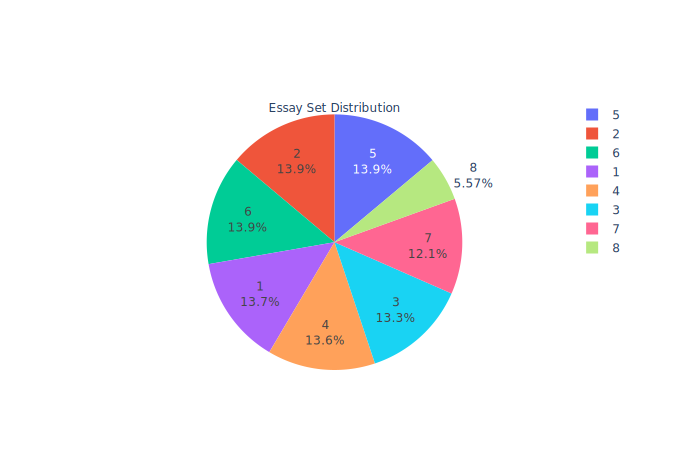

In [13]:
essaySet_labels = essay_df["essay_set"].value_counts().index
essaySet_freqs = essay_df["essay_set"].value_counts().values
essay_set_pie = go.Figure(data=[go.Pie(labels=essaySet_labels, values=essaySet_freqs, title="Essay Set Distribution", textinfo="label+percent")])
essay_set_pie.show("svg")

# Visualization of top 10 scores

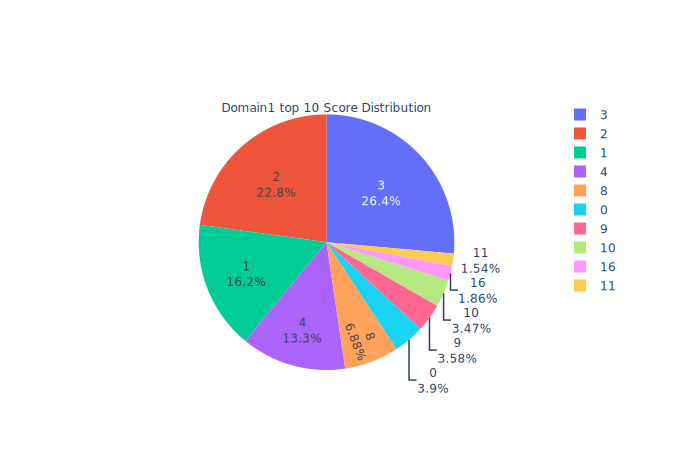

<Figure size 432x288 with 0 Axes>

In [14]:
domain1Score_labels = essay_df["domain1_score"].value_counts()[:10].index
domain1Score_freqs = essay_df["domain1_score"].value_counts()[:10].values
domain1_score_pie = go.Figure(data=[go.Pie(labels=domain1Score_labels, values=domain1Score_freqs, title="Domain1 top 10 Score Distribution", textinfo="label+percent")])
plt.savefig("top_10_scores.png")
domain1_score_pie.show("svg")
essay_set_pie.write_image("top_10_scores_pie.png")

# Data preprocessing
## Cleaning non-letters & tokenizing

In [15]:
essay_df.head()

,essay_id,essay_set,essay,domain1_score
0,1,1,"Dear local newspaper, I think effects computer...",8
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10
4,5,1,"Dear @LOCATION1, I know having computers has a...",8


In [16]:
# %%time
# essay_df["essay"] = essay_df["essay"].apply(lambda essay: clean_stopwords(clean_text(essay)))
# essay_df.to_pickle("./clean_stopwords_train_df.pkl")

In [17]:
essay_df = pd.read_pickle("./clean_stopwords_train_df.pkl")

In [18]:
essay_df.head()

,essay_id,essay_set,essay,domain1_score
0,1,1,"[dear, local, newspaper, think, effects, compu...",8
1,2,1,"[dear, believe, using, computers, benefit, us,...",9
2,3,1,"[dear, people, use, computers, everyone, agree...",7
3,4,1,"[dear, local, newspaper, found, many, experts,...",10
4,5,1,"[dear, know, computers, positive, effect, peop...",8


# Plot the average length of essays after cleaning and removing stopwords in each set

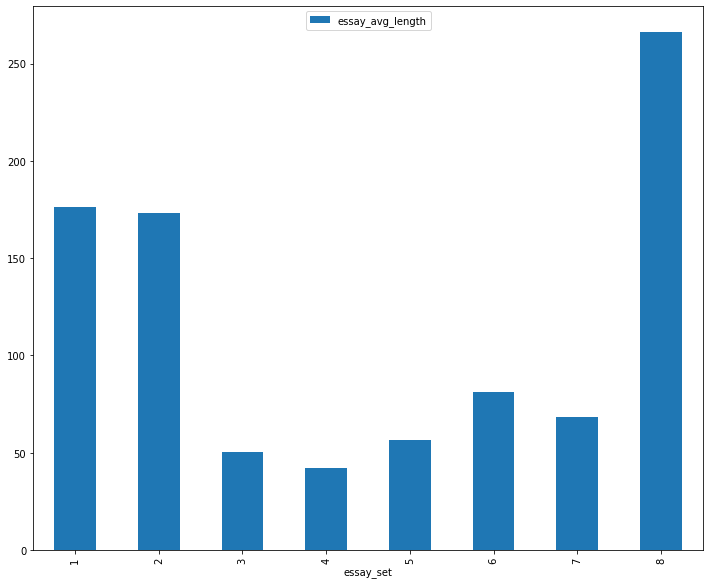

In [19]:
essay_set_length_df = pd.DataFrame({"essay_avg_length":  essay_df["essay"].apply(lambda essay: len(essay))})
essay_set_length_df["essay_set"] = essay_df["essay_set"].values 
essay_set_length_df = essay_set_length_df.groupby("essay_set").mean()
fig, ax = plt.subplots(figsize=(12,10))
essay_set_length_df.plot(ax=ax, kind="bar")
plt.legend(loc="upper center")
plt.savefig("essay_avg_length.png")
plt.show()


# Plot most top 20 frequent words after cleaning

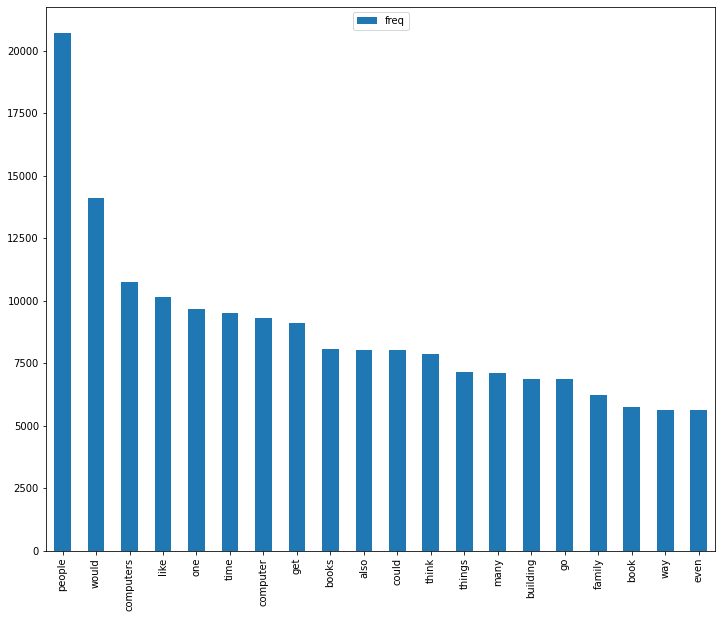

In [20]:
word_count_df = pd.DataFrame({ "freq": Counter(list(itertools.chain(*essay_df.essay.tolist()))) }).sort_values(by="freq", ascending=False)
fig, ax = plt.subplots(figsize=(12,10))
word_count_df.head(20).plot(ax=ax, kind="bar")
plt.legend(loc="upper center")
plt.savefig("top_20_freq_words.png")
plt.show()

## Define X: the input data, y: the input labels

In [21]:
# training input data observations X
X = essay_df.copy()
X

,essay_id,essay_set,essay,domain1_score
0,1,1,"[dear, local, newspaper, think, effects, compu...",8
1,2,1,"[dear, believe, using, computers, benefit, us,...",9
2,3,1,"[dear, people, use, computers, everyone, agree...",7
3,4,1,"[dear, local, newspaper, found, many, experts,...",10
4,5,1,"[dear, know, computers, positive, effect, peop...",8
...,...,...,...,...
12971,21626,8,"[stories, mothers, daughters, either, enemies,...",35
12972,21628,8,"[never, understood, meaning, laughter, shortes...",32
12973,21629,8,"[laugh, habit, cause, causes, laughing, even, ...",40
12974,21630,8,"[trippin, fences, years, young, short, years, ...",40


In [22]:
# training input labels y
y = essay_df["domain1_score"]
y

0         8
1         9
2         7
3        10
4         8
         ..
12971    35
12972    32
12973    40
12974    40
12975    40
Name: domain1_score, Length: 12976, dtype: int64

## Using KFold cross validation to train and test our model

### Loading Google Word2Vec model

In [23]:
%%time
w2v_model = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)

Wall time: 2min 18s


## Using `LSTM` 

In [24]:
%%time
n_of_splits = 2
kf = KFold(n_splits=n_of_splits, shuffle=True)
koppa_score_results = []           # stores the scores of koppa in each split

counter = 1
for traincv, testcv in kf.split(X):
    print("\n -------------------- Fold {} of {} --------------------\n".format(counter, n_of_splits))
    X_train, X_text, y_train, y_test = X.iloc[traincv], X.iloc[testcv], y.iloc[traincv], y.iloc[testcv]

    # Extracting essays from train & test dataframes
    train_essays = X_train["essay"]
    test_essays = X_text["essay"]

    # Convert train and test data observations into numeric vectors of 300-dim using `Word2Vec` model
    trainAvgVector = getAvgFeatureVector(train_essays.tolist(), w2v_model)
    testAvgVector = getAvgFeatureVector(test_essays.tolist(), w2v_model)

    # Reshape vectors by wrapping each vector with a list to repare to feed them to `LSTM` model
    trainAvgVector = np.reshape(trainAvgVector, (trainAvgVector.shape[0], 1, trainAvgVector.shape[1]))
    testAvgVector = np.reshape(testAvgVector, (testAvgVector.shape[0], 1, testAvgVector.shape[1]))

    # Initializing `LSTM` model & traning with input data
    lstm_model = get_lstm_model()
    lstm_model.fit(trainAvgVector, y_train, batch_size=64, epochs=4)

    # # Predicting and testing using test observations
    y_pred = lstm_model.predict(testAvgVector)
    y_pred = np.around(y_pred)

    #  Model Evaluation
    score = cohen_kappa_score(y_test.values, y_pred, weights='quadratic')
    koppa_score_results.append(score)
    print("Koppa Score: [ {} ]".format(score))

    # Save the first LSTM model 
    if counter == 1:
        lstm_model.save_weights("lstm_model.h5")
    
    # Save LSTM model prediction 
    pickle_save(y_pred, LSTM_PREDICTIONS)

    counter += 1
    


 -------------------- Fold 1 of 2 --------------------

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 300)            721200    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 814,705
Trainable params: 814,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
102/102 [==============================] - 10s 17ms/step - loss: 94.6455 - mae: 5.6079
Epoch 2/4
102/102 [==============================] - 2s 17ms/step - loss: 50.7507 - mae: 3.946

## Evaluation

In [26]:
print("Using LSTM: Average Kappa score after a 5-fold cross validation: [ ",np.around(np.array(koppa_score_results).mean(),decimals=4), "]")

Using LSTM: Average Kappa score after a 5-fold cross validation: [  0.7896 ]
